# CNN

In [72]:
import torch
import torchvision 
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as tfs
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

## MNIST

In [73]:
transform = tfs.Compose([
                         tfs.ToTensor()
])

batch_size = 4
root = "./data"

trainset = torchvision.datasets.MNIST(root=root, train=True, 
                                      transform=transform, download=True)
testset = torchvision.datasets.MNIST(root=root, train=False, transform=transform, download=True)

train_loader = DataLoader(trainset, batch_size=batch_size, 
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size,
                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))


In [74]:
train_loader.dataset.train_data.shape

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

In [75]:
test_loader.dataset.test_data.shape

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([10000, 28, 28])

In [76]:
train_loader.dataset.train_data[0]

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [77]:
numpy_image = train_loader.dataset.train_data[0].numpy()

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [78]:
numpy_image.shape

(28, 28)

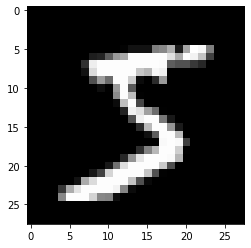

In [79]:
plt.imshow(numpy_image, cmap="gray")

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


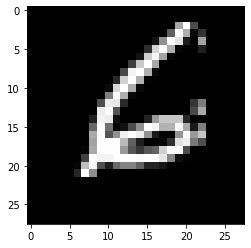

In [80]:
i = np.random.randint(low=0, high=60000)
plt.imshow(train_loader.dataset.train_data[i].numpy(), cmap="gray")

torch.Size([4, 1, 28, 28])


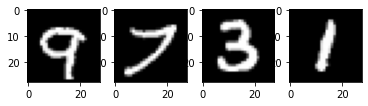

In [81]:
images, target = next(iter(train_loader))
print(images.shape)
for i in range(images.shape[0]):
  plt.subplot(1, images.shape[0], i + 1)
  plt.imshow(images[i, 0, :, :].numpy(), cmap="gray")

In [82]:
import torch.nn.functional as F


In [83]:
class SimpleConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.fc1 = nn.Linear(4 * 4 * 16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 256)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [84]:
net = SimpleConvNet()

summary(net.to(device), (1, 28, 28), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [4, 6, 24, 24]             156
         MaxPool2d-2             [4, 6, 12, 12]               0
            Conv2d-3              [4, 16, 8, 8]           2,416
         MaxPool2d-4              [4, 16, 4, 4]               0
            Linear-5                   [4, 120]          30,840
            Linear-6                    [4, 84]          10,164
            Linear-7                    [4, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.18
Params size (MB): 0.17
Estimated Total Size (MB): 0.36
----------------------------------------------------------------


In [85]:
epochs = 5
learning_rate = 1e-3

net.to(device)
optimizer = Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 0, loss: 156.1852494937075


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 1, loss: 117.36909417480283


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 2, loss: 96.48566124283478


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 3, loss: 102.86554810488755


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 4, loss: 89.77534329586909


Text(0.5, 0, 'Batch Iteration')

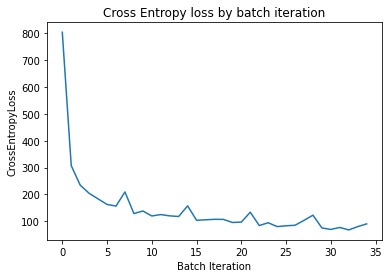

In [86]:
from tqdm.notebook import tqdm, trange

losses_history = []
running_loss = 0

for epoch in trange(epochs):
  for i, (x_batch, y_batch) in enumerate(tqdm(train_loader)):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    y_preds = net(x_batch)

    loss = criterion(y_preds, y_batch)
    running_loss += loss.item()
    if i % 2000 == 1999:
      losses_history.append(running_loss)
      running_loss = 0
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch}, loss: {losses_history[-1]}")

plt.plot(losses_history)
plt.title("Cross Entropy loss by batch iteration")
plt.ylabel("CrossEntropyLoss")
plt.xlabel("Batch Iteration")

In [87]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for images, labels in test_loader:
    y_pred = net(images.to(device))
    predicted = torch.argmax(y_pred, dim=1)

    c = (predicted.cpu() == labels).numpy()
    for i in range(batch_size):
      label = labels[i]
      class_correct[label] += c[i]
      class_total[label] += 1

for i in range(10):
  print(f"Accuracy of {i}: {100 * class_correct[i] / class_total[i]}")

Accuracy of 0: 99.08163265306122
Accuracy of 1: 99.64757709251101
Accuracy of 2: 98.25581395348837
Accuracy of 3: 98.61386138613861
Accuracy of 4: 99.59266802443992
Accuracy of 5: 99.10313901345292
Accuracy of 6: 98.43423799582463
Accuracy of 7: 98.92996108949416
Accuracy of 8: 99.17864476386038
Accuracy of 9: 96.33300297324084


### Задача 1

Протестируйте эту нейросеть на отдельных картинках из тестового датасета: напишите функцию, которая принимает индекс картинки в тестовом датасете, отрисовывает её, потом запускает на ней модель (нейросеть) и выводит результат предсказания.

In [97]:
def test_model(model, test_dataset, image_index):
  image, label = test_dataset[image_index]
  prediction = torch.argmax(model(image[None, :, :, :].to(device)))
  plt.imshow(image.view(28, 28).numpy(), cmap="gray")
  plt.title(f"Prediction: {prediction}, True: {label}")

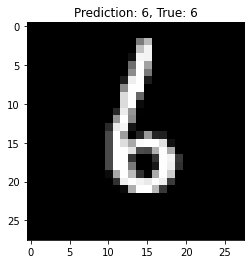

In [99]:
test_model(net, testset, 4599)

## CIFAR10

In [129]:
transform = tfs.Compose([
                         tfs.ToTensor(),
                         tfs.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

root = "./data"
train_set = torchvision.datasets.CIFAR10(root=root, train=True,
                                         transform=transform, download=True)
test_set = torchvision.datasets.CIFAR10(root=root, train=False, 
                                        transform=transform, download=True)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, 
                          shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, 
                         shuffle=False, num_workers=2, drop_last=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


(32, 32, 3)


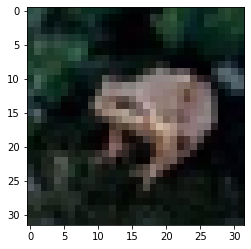

In [138]:
i = np.random.randint(low=0, high=50000)
print(train_loader.dataset.data[i].shape)
plt.imshow(train_loader.dataset.data[i])

### Задача 2-3

Напишите свою свёрточную нейросеть для предсказания на CIFAR10.

In [106]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 32, 32])

In [107]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2)
    self.fc1 = nn.Linear(3 * 3 * 256, 256)
    self.fc2 = nn.Linear(256, 64)
    self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1, 3 * 3 * 256)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [119]:
learning_rate = 1e-3
epochs = 10
model = ConvNet()
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [120]:
summary(model.to(device), (3, 32, 32), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 30, 30]           1,792
         MaxPool2d-2           [32, 64, 15, 15]               0
            Conv2d-3          [32, 128, 14, 14]          32,896
         MaxPool2d-4            [32, 128, 7, 7]               0
            Conv2d-5            [32, 256, 6, 6]         131,328
         MaxPool2d-6            [32, 256, 3, 3]               0
            Linear-7                  [32, 256]         590,080
            Linear-8                   [32, 64]          16,448
            Linear-9                   [32, 10]             650
Total params: 773,194
Trainable params: 773,194
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 28.13
Params size (MB): 2.95
Estimated Total Size (MB): 31.45
-----------------------------------------

In [121]:
running_loss = 0
losses_history = []

for epoch in trange(epochs):
  for i, (x_batch, y_batch) in enumerate(tqdm(train_loader)):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    y_preds = model(x_batch)
    loss = criterion(y_preds, y_batch)
    running_loss += loss.item()

    if i % 250 == 249:
      losses_history.append(running_loss)
      running_loss = 0
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  print(f"Epoch {epoch + 1}, Loss: {losses_history[-1]}")



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1, Loss: 296.5553897023201


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2, Loss: 231.15910977125168


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3, Loss: 186.3907431513071


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4, Loss: 168.85365489125252


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5, Loss: 147.09324738383293


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6, Loss: 125.22767922282219


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7, Loss: 110.81390178203583


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8, Loss: 95.49616970866919


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9, Loss: 83.17581741511822


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10, Loss: 70.2366242557764


Text(0, 0.5, 'Loss')

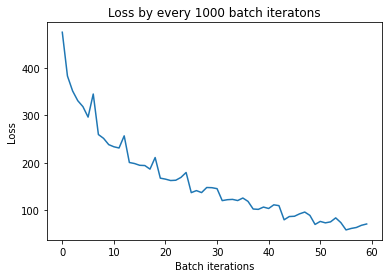

In [122]:
plt.plot(losses_history)

plt.title("Loss by every 1000 batch iteratons")
plt.xlabel("Batch iterations")
plt.ylabel("Loss")

In [130]:
class_correct = [0. for i in range(10)]
class_total = [0. for i in range(10)]

with torch.no_grad():
  for images, labels in tqdm(test_loader):
    y_preds = model(images.to(device))
    predicted = torch.argmax(y_preds, dim=1)
    c = (predicted.cpu() == labels).numpy()

    for i in range(batch_size):
      label = labels[i]
      class_correct[label] += c[i]
      class_total[label] += 1

for i, label in enumerate(classes):
  print(f"Accuracy of {label}: {np.round(100 * class_correct[i] / class_total[i])}")

  0%|          | 0/312 [00:00<?, ?it/s]

Accuracy of plane: 70.0
Accuracy of car: 81.0
Accuracy of bird: 67.0
Accuracy of cat: 52.0
Accuracy of deer: 78.0
Accuracy of dog: 72.0
Accuracy of frog: 86.0
Accuracy of horse: 70.0
Accuracy of ship: 89.0
Accuracy of truck: 79.0


In [146]:
def test_model(model, test_set, image_index):
  image, label = test_set[image_index]
  with torch.no_grad():
    prediction = torch.argmax(model(image[None, :, :, :].to(device)))
  plt.imshow(image.permute(1, 2, 0).cpu().data)
  plt.title(f"Prediciton: {classes[prediction]}, True: {classes[label]}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


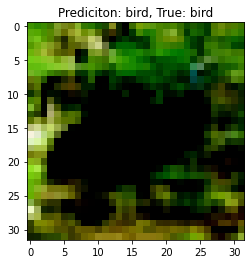

In [154]:
test_model(model, test_set, np.random.randint(low=0, high=10000))